In [29]:
# %load 'HW9'
#!/usr/bin/env python3
"""
Created on Sun Apr 15 00:18:32 2018

@author: Yangfan Cui
"""

import pandas as pd
from sklearn.datasets import load_breast_cancer
##  Q1
Cancer = load_breast_cancer()
print(Cancer['feature_names'])
print(Cancer['data'].shape)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']
(569, 30)


In [30]:
##Q2
print('The number of input: ',len(Cancer['feature_names']))

The number of input:  30


In [31]:
##Q3
target = pd.DataFrame(Cancer['target'])
target['1'] = 1- target
X = Cancer['data']
y = target.values
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 1)

In [32]:
##Q4
###1)
import tensorflow as tf
tf.reset_default_graph()
x = tf.placeholder('float32', shape=(None, 30), name='x')###should have the same input size, which is 30
y = tf.placeholder('int64', shape=(None,2 ), name='y')
is_training = tf.placeholder(tf.bool, shape=(),name='is_training')
print('Shape of "x" =',x.shape)
print('Shape of "y" =',y.shape)
print('Shape of "is_training" =',is_training.shape)

Shape of "x" = (?, 30)
Shape of "y" = (?, 2)
Shape of "is_training" = ()


In [33]:
###2)build layers
scaled = tf.contrib.layers.batch_norm(x, center=True,
                                      scale=True, scope='scaled',
                                      is_training=is_training)
hidden1 = tf.contrib.layers.fully_connected(scaled,
                                            num_outputs=5, scope='hidden1',
                                            activation_fn=tf.nn.relu)
hidden2 = tf.contrib.layers.fully_connected(hidden1,
                                            num_outputs=10, scope='hidden2',
                                            activation_fn=tf.nn.relu)
logits = tf.contrib.layers.fully_connected(hidden2,
                                           num_outputs=2, scope='logits',
                                           activation_fn=None)
output = tf.nn.softmax(logits, name='output')

In [34]:
###3) Prepare measures of goodness of fit: accuracy and logloss for logging
logloss = tf.losses.log_loss(predictions=tf.nn.softmax(logits), labels=y)
correct_prediction = tf.equal(tf.argmax(output, axis = 1), tf.argmax(y, axis = 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [35]:
def train(n_epochs, batch_size,trained_params_path): 
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)     
    with tf.control_dependencies(update_ops): 
        # Ensures that we execute the update_ops before performing the train_step         
        optimizer = tf.train.AdamOptimizer()         
        # Select type of optimizer         
        train_step = optimizer.minimize(logloss)         
        # Gradient descent step 
    sess = tf.Session()      

    sess.run(tf.global_variables_initializer())  # Initialize all variables     
    saver = tf.train.Saver()  # use saver to store trained model parameters on disk     
    best_epoch = 0     
    best_test_logloss = float("inf")     
    test_accuracy_for_best_test_logloss = 0 

    history = [] 
    for epoch in range(n_epochs): 
        batch_from = 0 
        while batch_from < len(y_train): 
            batch_to = min(batch_from + batch_size, len(y_train)) 
            x_trainbatch = x_train[batch_from:batch_to,] 
            y_trainbatch = y_train[batch_from:batch_to] 
            batch_from = batch_from + batch_size # for next iteration 
            sess.run(train_step, feed_dict ={x: x_trainbatch, y: y_trainbatch, is_training: True }) 
        # Run batches through the network until epoch is over 
        # Calculate statistics (logloss & accuracy) for train & test: 
        train_res = sess.run([logloss, accuracy], 
                             feed_dict ={x: x_train, y: y_train, is_training: False }) 
        test_res = sess.run([logloss, accuracy], 
                            feed_dict ={x: x_test, y: y_test, is_training: False }) 
        history += [[epoch] + train_res + test_res] 
        
        test_logloss = test_res[0] 
        test_accuracy = test_res[1] 
        if test_logloss < best_test_logloss: 
            # save params for best test logloss only 
            saver.save(sess, trained_params_path) 
            best_epoch = epoch 
            best_test_logloss = test_logloss 
            test_accuracy_for_best_test_logloss = test_accuracy 

    print('Best epoch is #{} with test logloss of {:.4f} (test_accuracy = {:.4f})'.format(best_epoch, best_test_logloss, test_accuracy_for_best_test_logloss))    
    sess.close()
    return history 

In [44]:
###b)Analyze the results
    ###1)– Plot the curve of logloss vs epoch
import matplotlib.pyplot as plt
df_h=train(1000, 40, './trained_variables.ckpt')
df_h=pd.DataFrame(df_h)
print(df_h.shape)

Best epoch is #310 with test logloss of 0.2044 (test_accuracy = 0.9474)
(1000, 5)


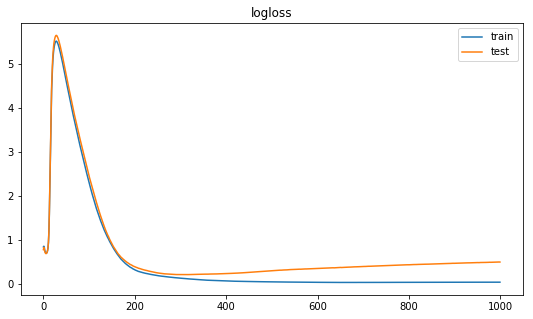

In [45]:
# Plot logloss for train & test

plt.figure(figsize=(9,5))
plt.plot(df_h.iloc[:,0], df_h.iloc[:,1], label='train') 
plt.plot(df_h.iloc[:,0], df_h.iloc[:,3], label='test') 
plt.title('logloss') 
plt.legend() 
plt.show()

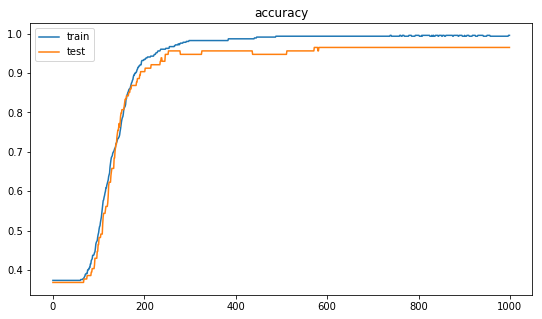

In [38]:
###2 – Plot the curve of accuracy vs epoch
plt.figure(figsize=(9,5))
plt.plot(df_h.iloc[:,0], df_h.iloc[:,2], label='train')
plt.plot(df_h.iloc[:,0], df_h.iloc[:,4], label='test')
plt.title('accuracy')
plt.legend()
plt.show()

From two graphs above, they show that on the begining of training, since it is underfit the model, the loss is high  and accuracy is low. After hundreds of epochs, the loss decreases and accuracy increases in to a stable level for both training set and test set.

INFO:tensorflow:Restoring parameters from ./trained_variables.ckpt
(114, 2)


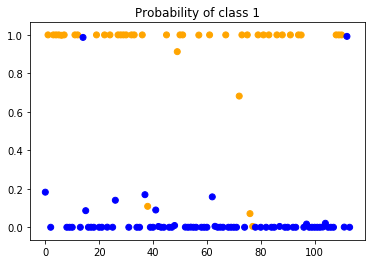

In [39]:
### predict
def predict(x_new, trained_params_path):
    with tf.Session() as sess:
        saver = tf.train.Saver()
        saver.restore(sess, trained_params_path)
        pr = output.eval(feed_dict={x: x_new, is_training:False})
        return pr
z = predict(x_test, './trained_variables.ckpt')
print(z.shape)
# blue for class 0, orange for class 1
color = ['blue' if y == 0 else 'orange' for y in y_test[:,1]]
plt.scatter(range(y_test.shape[0]), z[:,1], color=color)
plt.title('Probability of class 1')
plt.show()